In [157]:
%load_ext autoreload
%autoreload 2

import os
import sys
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import h5py
import scipy.stats as stats
from pvlib import pvsystem, location, modelchain, irradiance

sys.path.append('..')

from src.data import load_data
from src.utils import convert_pixel_to_coordinates

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

In [148]:
def generate_dataset(data, shift=20):
    df_data = pd.Series(data)/255
    # Compute the difference
    df_data = df_data.diff()

    DATA = pd.DataFrame({
        **{
            f"{i}": df_data.shift(i)
            for  i in range(shift)
        },
        **{
            
        },
        "Y": df_data.shift(shift),
    }).dropna()

    features = DATA.drop(columns=["Y"])
    labels = DATA["Y"]
    return features.values, labels.values
    return np.expand_dims(features.values, axis=1), labels.values

X_train, y_train = generate_dataset(load_data("../data/", 2020)[:, 200, 200])
X_val, y_val = generate_dataset(load_data("../data/", 2019)[:, 200, 200])
X_test, y_test = generate_dataset(load_data("../data/", 2018)[:, 200, 200])

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(35115, 20) (35115,)
(35019, 20) (35019,)
(35019, 20) (35019,)


In [ ]:
def search_day_AOI(loc_x: int, loc_y: int, day: str = "2019-01-01"):
    """Search the AOI for one day."""
    lat, long = convert_pixel_to_coordinates(loc_x, loc_y)
    loc = location.Location(lat, long)
    times = pd.date_range(
        f"{day} 00:15", f"{day} 23:45", freq="15min", tz="Etc/GMT+5"
    )
    weather = loc.get_solarposition(times)
    
    aoi = irradiance.aoi(0, 0, weather.apparent_zenith, weather.azimuth)
    return aoi.to_numpy()
search_day_AOI(200, 200)

In [149]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM

input_size = 1 if len(X_train.shape) == 1 else X_train.shape[1]
# create and fit the LSTM network
model = Sequential()
model.add(Input(shape=(input_size,1)))
model.add(LSTM(10, input_shape=(input_size,), return_sequences=True))
model.add(LSTM(10, input_shape=(10,)))  # (1, loop_back) # (1, input_sequence_length)
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=34,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=2,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=False,
        )
    ],
)


Epoch 1/50
1033/1033 - 17s - loss: 9.5218e-04 - val_loss: 9.6739e-04 - 17s/epoch - 16ms/step
Epoch 2/50
1033/1033 - 14s - loss: 9.3121e-04 - val_loss: 9.6469e-04 - 14s/epoch - 14ms/step
Epoch 3/50
1033/1033 - 14s - loss: 9.1477e-04 - val_loss: 9.2596e-04 - 14s/epoch - 13ms/step
Epoch 4/50
1033/1033 - 14s - loss: 8.9396e-04 - val_loss: 9.7161e-04 - 14s/epoch - 14ms/step
Epoch 5/50
1033/1033 - 14s - loss: 8.8764e-04 - val_loss: 9.2978e-04 - 14s/epoch - 13ms/step


In [150]:
history.__dict__.keys()

dict_keys(['validation_data', 'model', '_chief_worker_only', '_supports_tf_logs', 'history', 'params', 'epoch'])

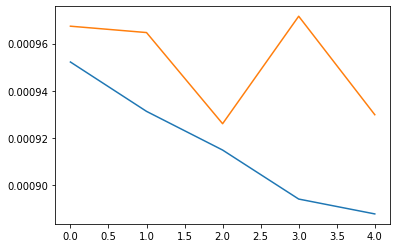

In [151]:
plt.plot(history.epoch, history.history['loss']);
plt.plot(history.epoch, history.history['val_loss']);

In [152]:
y_pred = model.predict(X_test)


In [153]:
N = 96*5

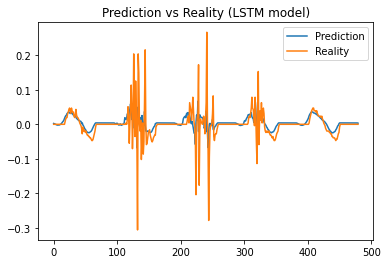

In [154]:
plt.plot(y_pred[:N], label="Prediction")
plt.plot(y_test[:N], label="Reality");
plt.legend()
plt.title('Prediction vs Reality (LSTM model)')
plt.show()

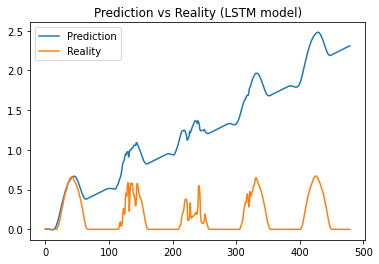

In [155]:
plt.plot(np.cumsum(y_pred)[:N], label="Prediction")
plt.plot(np.cumsum(y_test)[:N], label="Reality");
plt.legend()
plt.title('Prediction vs Reality (LSTM model)')
plt.show()